In [1]:
# Check package versions
import gammapy
import numpy as np
import astropy
import regions
import matplotlib

print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)
print("matplotlib", matplotlib.__version__)

gammapy: 0.19
numpy: 1.21.2
astropy 4.3.1
regions 0.5
matplotlib 3.5.1


In [2]:
%matplotlib inline
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('tableau-colorblind10')
from matplotlib.offsetbox import AnchoredText
from pathlib import Path
from regions import CircleSkyRegion

from gammapy.maps import Map, RegionGeom
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    MapDataset,
)
from gammapy.maps import MapAxis, WcsGeom
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker
)
from gammapy.estimators import ExcessMapEstimator
from scipy.stats import norm

from acceptance_modelisation import RadialAcceptanceMapCreator

In [3]:
location_data = '/home/lavergne/Téléchargements/hess_dl3_dr1/' #path to DL3 folder
source_name = 'Crab' #e.g., Crab, GRB210807A
cut_type = 'loose' #e.g., loose, hard, ...
filename_output = '{name}_{cut}'.format(name=source_name, cut=cut_type)

In [4]:
source_position = SkyCoord.from_name('Crab')
max_offset_run = 2.5 * u.deg

In [5]:
#If not existing create folder to store the images in the current folder
work_directory = os.getcwd()
path_plot = Path(work_directory+"/figures")
path_plot.mkdir(exist_ok=True)
path_background = Path(work_directory+"/background")
path_background.mkdir(exist_ok=True)

In [6]:
e_min = 0.01 * u.TeV
e_max = 20. * u.TeV
n_bin_per_decade = 10
on_radius = 0.2 * u.deg
exclusion_radius = 0.5*u.deg
fov_observation = 2.5*u.deg

In [7]:
r_in = 0.5*u.deg
width = 0.4*u.deg
correlation_radius = 0.12 * u.deg

In [8]:
n_bin_per_decade_acceptance = 2.5
offset_bin_size_acceptance = 0.4*u.deg

# Load Data

In [9]:
data_store = DataStore.from_dir(location_data)

In [10]:
data_store.info()

Data store:
HDU index table:
BASE_DIR: /home/lavergne/Téléchargements/hess_dl3_dr1
Rows: 525
OBS_ID: 20136 -- 47829
HDU_TYPE: ['aeff', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 105



In [11]:
data_store.obs_table

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
20136,228.6125,-58.771667,320.56754,-0.8857012,38.512962,51.487038,195.73102,MSH15-52,228.6125,-59.271667,0.5,1682.0,1521.0269,0.9042966,101962602.0,101964284.0,2004-03-26,02:57:46.184,2004-03-26,03:25:48.184,4,"1,2,3,4",0,1.2132596,11243,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20137,228.6125,-59.771667,320.04724,-1.7397733,40.21616,49.78384,199.6482,MSH15-52,228.6125,-59.271667,0.5,902.0,819.2054,0.90821,101964441.0,101965343.0,2004-03-26,03:28:25.184,2004-03-26,03:43:27.184,4,"1,2,3,4",0,1.2139559,5693,MSH 15-52,msh1552,0.6156251,0.40738028,100.0
20151,228.6125,-58.771667,320.56754,-0.8857012,37.164658,52.835342,190.97171,custom,228.6125,-59.271667,0.5,1683.0,1530.479,0.9093755,102047232.0,102048915.0,2004-03-27,02:28:16.184,2004-03-27,02:56:19.184,4,"1,2,3,4",0,1.2214733,10722,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20275,187.27792,2.552389,289.7155,64.849686,36.18243,53.81757,49.144917,3C 273,187.27792,2.052389,0.5,1683.0,1525.8447,0.90662193,103665036.0,103666719.0,2004-04-14,19:51:40.184,2004-04-14,20:19:43.184,4,"1,2,3,4",0,1.121256,10646,Off data,offdata,--,0.33113113,100.0
20282,228.6125,-58.771667,320.56754,-0.8857012,37.13134,52.86866,169.21602,MSH 15-5-02,228.6125,-59.271667,0.5,1687.0,1543.3231,0.9148329,103678269.0,103679956.0,2004-04-14,23:32:13.184,2004-04-15,00:00:20.184,4,"1,2,3,4",0,1.1495326,11063,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20283,228.6125,-59.771667,320.04724,-1.7397733,36.221436,53.778564,175.77263,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1547.8253,0.9196823,103680087.0,103681770.0,2004-04-15,00:02:31.184,2004-04-15,00:30:34.184,4,"1,2,3,4",0,1.1512518,7628,MSH 15-52,msh1552,0.6156251,0.3801894,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47802,330.29538,-30.225555,17.818897,-52.742733,36.828686,53.171314,110.0,PKS 2155-304,329.71667,-30.225555,0.50002956,1688.0,1572.4065,0.9315204,241558291.0,241559979.0,2008-08-27,19:32:35.184,2008-08-27,20:00:43.184,4,"1,2,3,4",0,0.9731573,5998,PKS 2155-304 (steady),pks2155_steady,0.4998021,0.61659503,100.0


In [12]:
#Select all runs automatically, otherwise specify single runs.
#obs_ids = [5543, 5544, 5545]
obs_ids = data_store.obs_table[source_position.separation(data_store.obs_table.pointing_radec) < max_offset_run]['OBS_ID']
obs_collection = data_store.get_observations(obs_ids, required_irf=None)

No HDU found matching: OBS_ID = 23523, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 23523, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 23526, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 23526, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 23559, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 23559, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 23592, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 23592, HDU_TYPE = rad_max, HDU_CLASS = None


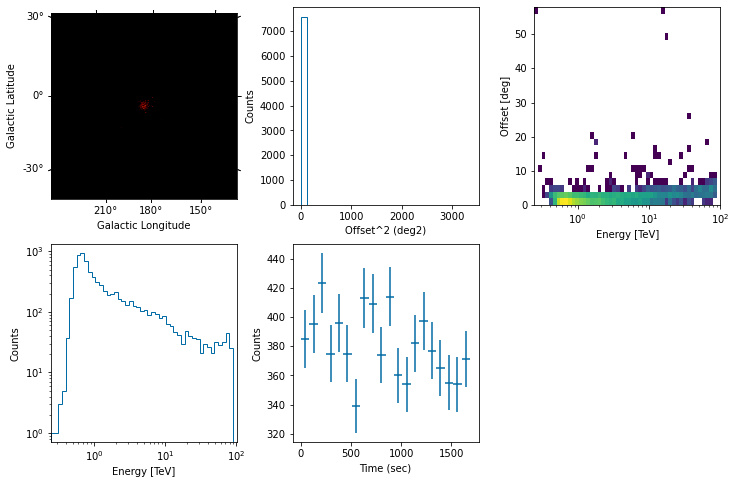

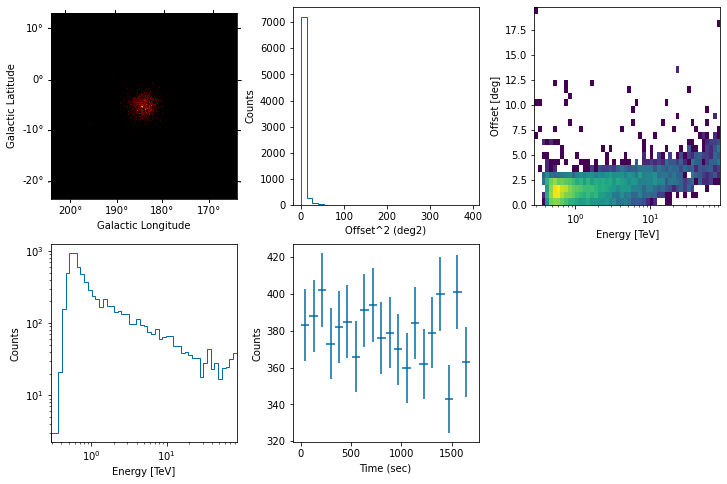

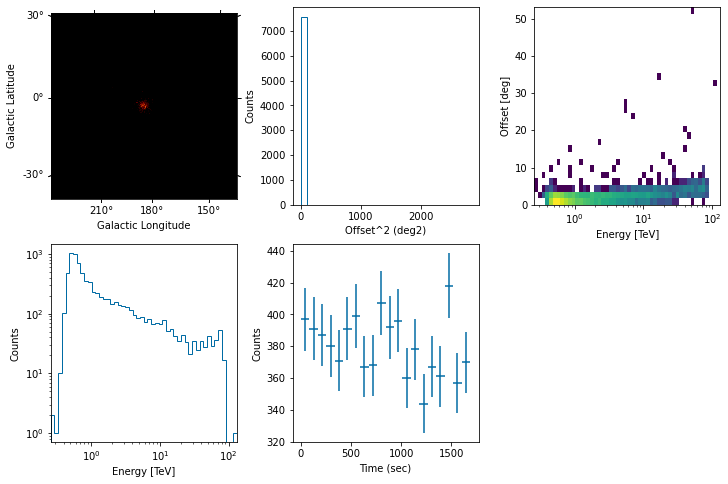

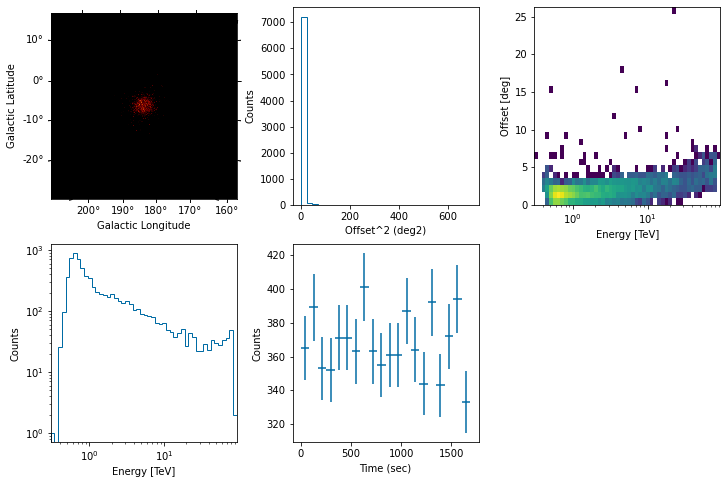

In [13]:
for i in range(len(obs_collection)):
    obs_collection[i].events.peek()

# Define on Region and exclusion region

In [14]:
exclude_region = CircleSkyRegion(center=source_position, radius=exclusion_radius)

In [15]:
n_bin_energy = int((np.log10(e_max.to_value(u.TeV))-np.log10(e_min.to_value(u.TeV)))*n_bin_per_decade)
energy_axis = MapAxis.from_edges(
    np.logspace(np.log10(e_min.to_value(u.TeV)), np.log10(e_max.to_value(u.TeV)), n_bin_energy+1), unit="TeV", name="energy", interp="log"
)
maximal_run_separation = np.max(source_position.separation(data_store.obs_table[np.isin(data_store.obs_table['OBS_ID'], obs_ids)].pointing_radec))
geom = WcsGeom.create(
    skydir=source_position, width=((maximal_run_separation+fov_observation)*2.5, (maximal_run_separation+fov_observation)*2.5), binsz=0.02, frame="icrs", axes=[energy_axis]
)
geom

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (500, 500, 33)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 22.0 deg
	width      : 10.0 deg x 10.0 deg
	wcs ref    : 83.6 deg, 22.0 deg

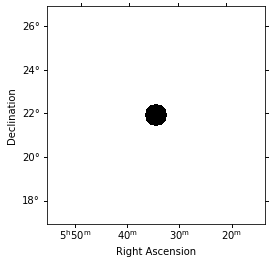

In [16]:
geom_image = geom.to_image()
exclusion_mask = ~geom_image.region_mask([exclude_region])
exclusion_mask.sum_over_axes().plot();

/home/lavergne/software/miniconda3/envs/lst-analysis/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


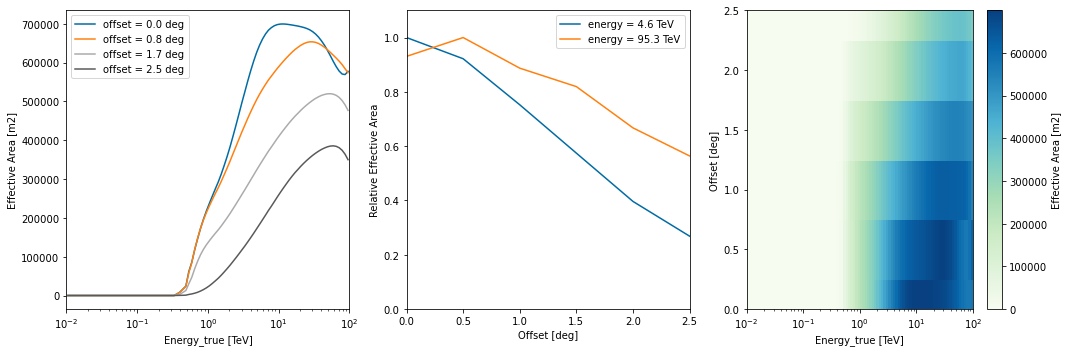

In [17]:
if obs_collection[0].aeff is not None:
    obs_collection[0].aeff.peek()

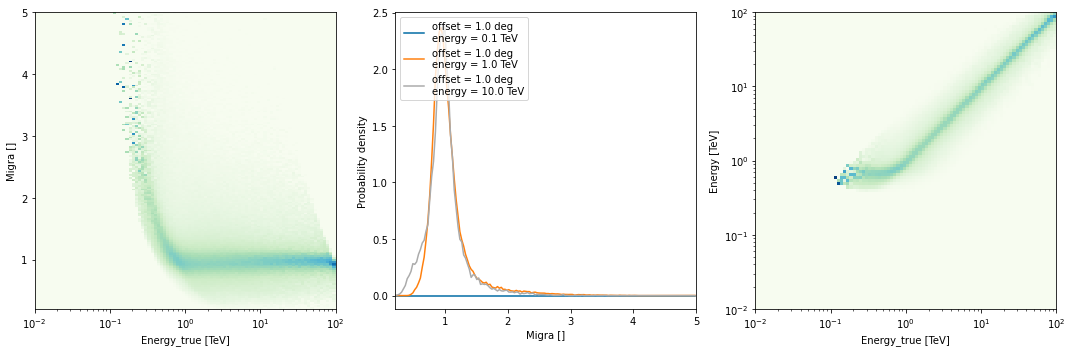

In [18]:
if obs_collection[0].edisp is not None:
    obs_collection[0].edisp.peek()

In [19]:
if obs_collection[0].bkg is not None:
    obs_collection[0].bkg.peek()

# Count Map

In [20]:
stacked = MapDataset.create(geom=geom, name=source_name+'_stacked')
unstacked = Datasets()
maker = MapDatasetMaker(selection=["counts"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=fov_observation)

for obs in obs_collection:
    cutout = stacked.cutout(obs.pointing_radec, width="6.5 deg")
    dataset = maker.run(cutout, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    stacked.stack(dataset)
    unstacked.append(dataset)

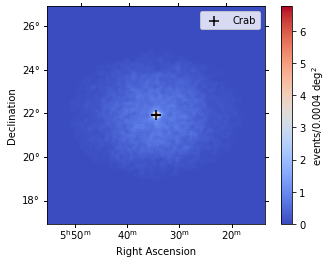

In [21]:
stacked.to_image().counts.smooth('0.12 deg', kernel='disk').plot(add_cbar=True, cmap='coolwarm')
cbar = plt.gca().images[-1].colorbar
cbar.ax.get_yaxis().labelpad = 5
cbar.ax.set_ylabel(r'events/0.0004 deg$^2$', rotation=90)
plt.gca().scatter(source_position.ra, source_position.dec, transform=plt.gca().get_transform('world'), marker='+', c='k', label=source_name, s=100)
plt.legend()

plt.savefig(os.path.join(path_plot,'{}__countmap.png'.format(filename_output)), dpi=300)

# Create acceptance model from data

In [22]:
n_bin_energy_acceptance = int((np.log10(e_max.to_value(u.TeV))-np.log10(e_min.to_value(u.TeV)))*n_bin_per_decade_acceptance)
energyAxisAcceptance = MapAxis.from_edges(
    np.logspace(np.log10(e_min.to_value(u.TeV)), np.log10(e_max.to_value(u.TeV)), 1+n_bin_energy_acceptance), unit="TeV", name="energy", interp="log"
)
n_bin_offset_acceptance = int(fov_observation.to_value(u.deg)/offset_bin_size_acceptance.to_value(u.deg))
offsetAxisAcceptance = MapAxis.from_edges(
    np.linspace(0., fov_observation.to_value(u.deg), 1+n_bin_offset_acceptance), unit="deg", name="offset", interp="lin"
)

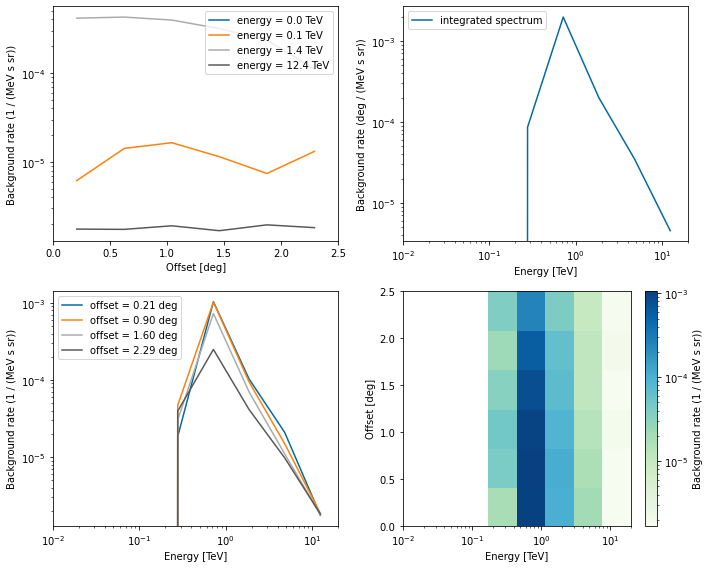

In [23]:
background_creator = RadialAcceptanceMapCreator(energyAxisAcceptance, offsetAxisAcceptance, exclude_regions=[exclude_region, ], oversample_map=20)
background = background_creator.create_radial_acceptance_map_per_observation(obs_collection)
background[list(background.keys())[0]].peek()
for obs_id in background.keys():
    hdu_background = background[obs_id].to_table_hdu()
    hdu_background.writeto(os.path.join(path_background,filename_output+'_'+str(obs_id)+'_background.fits'), overwrite=True)

In [24]:
data_store.hdu_table.remove_rows(data_store.hdu_table['HDU_TYPE']=='bkg')

In [25]:
for obs_id in np.unique(data_store.hdu_table['OBS_ID']):
    data_store.hdu_table.add_row({'OBS_ID': obs_id, 
                                  'HDU_TYPE': 'bkg',
                                  "HDU_CLASS": "bkg_2d",
                                  "FILE_DIR": "",
                                  "FILE_NAME": os.path.join(path_background,filename_output+'_'+str(obs_id)+'_background.fits'),
                                  "HDU_NAME": "BACKGROUND",
                                  "SIZE": hdu_background.size})

In [26]:
data_store.hdu_table = data_store.hdu_table.copy()
data_store.hdu_table

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME,SIZE
int64,bytes6,bytes9,bytes4,bytes96,bytes10,int64
20136,events,events,data,hess_dl3_dr1_obs_id_020136.fits.gz,events,414720
20136,gti,gti,data,hess_dl3_dr1_obs_id_020136.fits.gz,gti,5760
20136,aeff,aeff_2d,data,hess_dl3_dr1_obs_id_020136.fits.gz,aeff,11520
20136,edisp,edisp_2d,data,hess_dl3_dr1_obs_id_020136.fits.gz,edisp,377280
20136,psf,psf_table,data,hess_dl3_dr1_obs_id_020136.fits.gz,psf,118080
20137,events,events,data,hess_dl3_dr1_obs_id_020137.fits.gz,events,216000
...,...,...,...,...,...,...
33801,bkg,bkg_2d,,/home/lavergne/these/lstAnalysis/lst-analysis-script/background/Crab_loose_33801_background.fits,BACKGROUND,608
47802,bkg,bkg_2d,,/home/lavergne/these/lstAnalysis/lst-analysis-script/background/Crab_loose_47802_background.fits,BACKGROUND,608


In [27]:
obs_collection = data_store.get_observations(obs_ids, required_irf=None)

No HDU found matching: OBS_ID = 23523, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 23526, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 23559, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 23592, HDU_TYPE = rad_max, HDU_CLASS = None


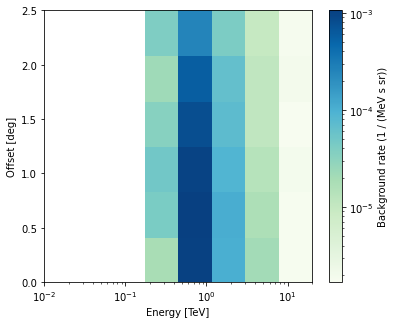

In [28]:
plt.figure(figsize=(6, 5))
obs_collection[0].bkg.plot()
plt.savefig(os.path.join(path_plot,'{}__bkg_model.png'.format(filename_output)), dpi=300)

In [29]:
stacked = MapDataset.create(geom=geom)
unstacked = Datasets()
maker = MapDatasetMaker(selection=["counts", "background"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=fov_observation)

for obs in obs_collection:
    cutout = stacked.cutout(obs.pointing_radec, width="6.5 deg")
    dataset = maker.run(cutout, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    stacked.stack(dataset)
    unstacked.append(dataset)

In [30]:
ring_bkg_maker = RingBackgroundMaker(r_in=r_in, width=width, exclusion_mask=exclusion_mask)
stacked_ring = ring_bkg_maker.run(stacked.to_image())
estimator = ExcessMapEstimator(correlation_radius, correlate_off=False)
lima_maps = estimator.run(stacked_ring)

/home/lavergne/software/miniconda3/envs/lst-analysis/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [31]:
significance_all = lima_maps["sqrt_ts"].data[np.isfinite(lima_maps["sqrt_ts"].data)]
significance_background = lima_maps["sqrt_ts"].data[np.logical_and(np.isfinite(lima_maps["sqrt_ts"].data), exclusion_mask.data)]

bins = np.linspace(np.min(significance_all), np.max(significance_all), num=int((np.max(significance_all)-np.min(significance_all))*3))

# Now, fit the off distribution with a Gaussian
mu, std = norm.fit(significance_background)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)

Fit results: mu = -0.02, std = 1.05


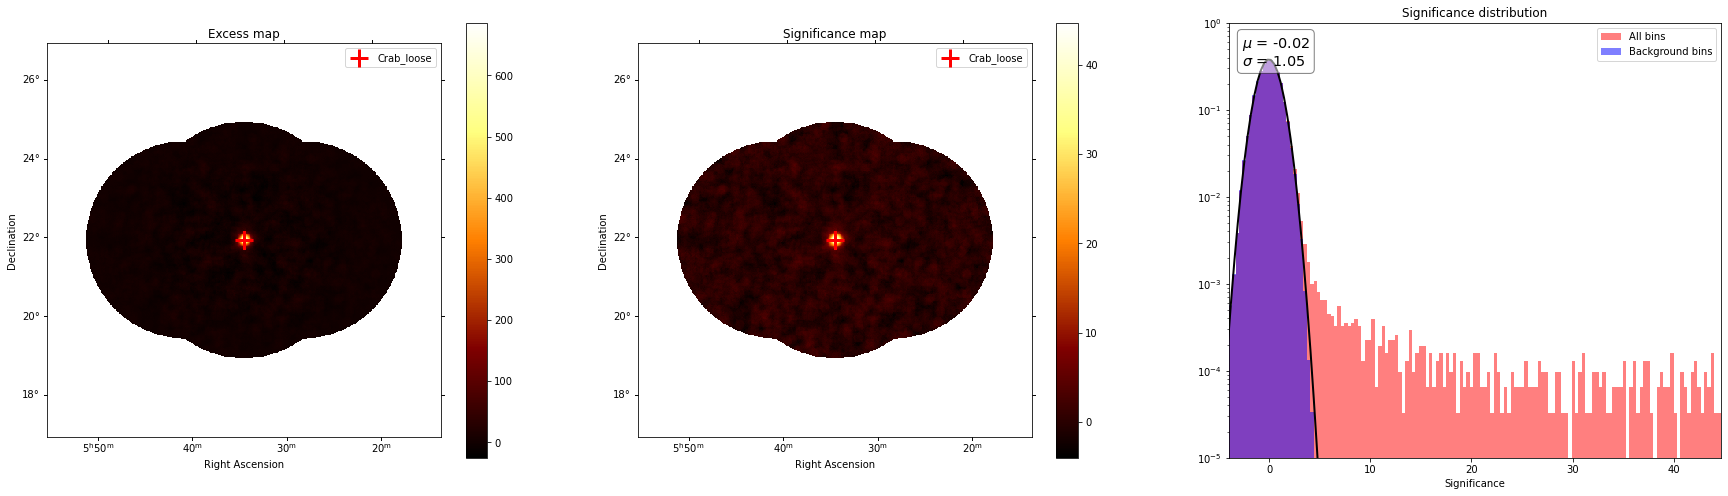

In [32]:
plt.figure(figsize=(30, 8))
ax1 = plt.subplot(1,3,1, projection=lima_maps["sqrt_ts"].geom.wcs)
ax2 = plt.subplot(1,3,2, projection=lima_maps["sqrt_ts"].geom.wcs)
ax3 = plt.subplot(1,3,3)

ax2.set_title("Significance map")
lima_maps["sqrt_ts"].plot(ax=ax2, add_cbar=True)
ax2.scatter(source_position.ra, source_position.dec, transform=ax2.get_transform('world'), marker='+', c='red', label=filename_output, s=[300], linewidths=3)
ax2.legend()

ax1.set_title("Excess map")
lima_maps["npred_excess"].plot(ax=ax1, add_cbar=True)
ax1.scatter(source_position.ra, source_position.dec, transform=ax1.get_transform('world'), marker='+', c='red', label=filename_output, s=[300], linewidths=3)
ax1.legend()

ax3.set_title("Significance distribution")
ax3.hist(significance_all,
         density=True,
         alpha=0.5,
         color="red",
         label="All bins",
         bins=bins)
ax3.hist(significance_background,
         density=True,
         alpha=0.5,
         color="blue",
         label="Background bins",
         bins=bins)

ax3.plot(x, p, lw=2, color="black")
ax3.legend()
ax3.set_xlabel("Significance")
ax3.set_yscale('log')
ax3.set_ylim(1e-5, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
ax3.set_xlim(xmin, xmax)

text = text = r'$\mu$ = {:.2f}'\
        f'\n'\
        r'$\sigma$ = {:.2f}'.format(mu,std)
box_prop = dict(boxstyle='Round', facecolor='white', alpha=0.5)
text_prop = dict(fontsize='x-large', bbox=box_prop)
txt = AnchoredText(text, loc=2, transform=ax3.transAxes, prop=text_prop, frameon=False)
ax3.add_artist(txt)

plt.savefig(os.path.join(path_plot,'{}__sky_map.png'.format(filename_output)), dpi=300)
print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")